# Transfer learning with tensorFlow Part1 : Feature extraction

Transfer learning is leveraging a working model's existing architecture and learend patterns for our own problem

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on probllems similar to oue own
2. Can leverage a working neural network architecture which has alredy learned patterns on similar data to our own then we can adapt those patterns to our own data

In [ ]:
#Are we using a GPU?
!nvidia-smi

Mon Dec 25 13:29:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Download and becoming one with the data

In [ ]:
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-12-25 13:29:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.4MB/s    in 4.2s    

2023-12-25 13:29:28 (37.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Unzip file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Inspect our data
import os

#Walk through 10% data directory
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the Imagedatagenerator class to load in our images in bathecs


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing data: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing data: 
Found 2500 images belonging to 10 classes.


## Seting up callbacks (thing to run whilist our mode)

Callbavks are extra functionality you can add to your models to be performed during or after training.
Some of the populat callbacks:
1. Tracking experiments with TensorBoard callbacks
2. Model checkpoint with the ModelCheckpoint callback
3. Stopping a model from training (before it train too long and overfiit)

In [ ]:
# Create TensorBoard callback (functioniezed because we need to create a new one for new model)

import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensroBoard log files to: {log_dir}")

  return tensorboard_callback

## Creating models using TENSORFLOW HUB

In the past we used Tensor Flow to create our own models layer by layer from scratch

Now we are going to do a similar process, except the majority of our models layers are going to come from TensorFlow Hub.

We can acces pretrained model on https://tfhub.dev/

We found this model :https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1?tfhub-redirect=true

and this one: https://www.kaggle.com/models/tensorflow/efficientnet

In [ ]:
# Lets compare the following two models
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"

efficient_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Lets make a create_model() function to create model from url
def create_model(model_url,num_classes=10):
  """
  Takes a Tensorflow hub url and creates a Keras Sequential model with it.

  Args:
    model_url(str): A tensorFlow Hub feature extraction URL.
    number_classes( int): Number of output neurons in the output layer
      should be equal to nubmer of target classes,default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """

  #Download the pretrained model and sace is as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, #Freeze the alredy learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])

  return model

### Creating Resnet TensorFlow Hub feature extraction model

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data,
                             validation_steps = len(test_data),
                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resnet50V2")])

Saving TensroBoard log files to: tensorflow_hub/resnet50V2/20231225 - 132940
Epoch 1/5
24/24 [==============================] - 35s 1s/step - loss: 1.9842 - accuracy: 0.3293 - val_loss: 1.1745 - val_accuracy: 0.6444
Epoch 2/5
24/24 [==============================] - 13s 542ms/step - loss: 0.8998 - accuracy: 0.7427 - val_loss: 0.8441 - val_accuracy: 0.7380
Epoch 3/5
24/24 [==============================] - 13s 536ms/step - loss: 0.6178 - accuracy: 0.8173 - val_loss: 0.7396 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 13s 566ms/step - loss: 0.4703 - accuracy: 0.8733 - val_loss: 0.7107 - val_accuracy: 0.7656
Epoch 5/5
24/24 [==============================] - 13s 537ms/step - loss: 0.3706 - accuracy: 0.9133 - val_loss: 0.6661 - val_accuracy: 0.7824


In [ ]:
efficient_model = create_model(efficient_url,num_classes=train_data_10_percent.num_classes)

In [ ]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficient_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficient_history = efficient_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps = len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientB0")])

Saving TensroBoard log files to: tensorflow_hub/efficientB0/20231225 - 133145
Epoch 1/5
24/24 [==============================] - 26s 616ms/step - loss: 1.8127 - accuracy: 0.4373 - val_loss: 1.2555 - val_accuracy: 0.7404
Epoch 2/5
24/24 [==============================] - 10s 447ms/step - loss: 1.0452 - accuracy: 0.7773 - val_loss: 0.8554 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 11s 459ms/step - loss: 0.7547 - accuracy: 0.8213 - val_loss: 0.6878 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 13s 541ms/step - loss: 0.6087 - accuracy: 0.8680 - val_loss: 0.6076 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 13s 540ms/step - loss: 0.5153 - accuracy: 0.8920 - val_loss: 0.5523 - val_accuracy: 0.8632


Wow!

This is incredible.Our model Transfer leraning feature extractor model out performs ALL of the previous models we build by hand... and in a quicker training time... And with only 10% training examples

In [ ]:
#Lets create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """

  loss= history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Acccuracy")
  plt.xlabel("Epochs")
  plt.legend();


In [ ]:
#plot_loss_curves(history_1) #First history of first model

In [ ]:
efficient_model1 = create_model(efficient_url,num_classes=train_data_10_percent.num_classes)

efficient_model1.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficient_history1 = efficient_model1.fit(train_data_10_percent,
                                          epochs=5,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps = len(test_data),
                                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientB0")],
                                          verbose=0)

Saving TensroBoard log files to: tensorflow_hub/efficientB0/20231225 - 133320


Details of efficientnet -> https://blog.research.google/2019/05/efficientnet-improving-accuracy-and.html

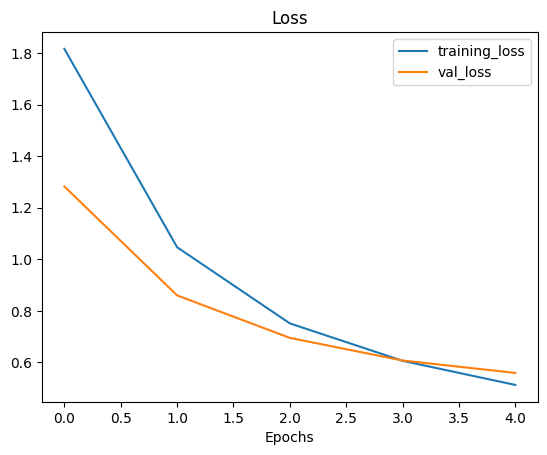

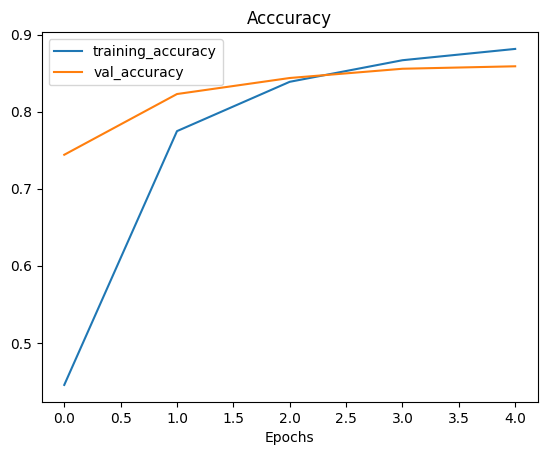

In [ ]:
plot_loss_curves(efficient_history1)

In [ ]:
efficient_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
len(efficient_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g using imagenet model on 1000 ImageNet classes)

* **"Feauture extraction"** - transfer learning - use the prelearned patterns of an existing model(e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem(e.g 1000 classes -> classes of food)

* **"Fine tuning" - =transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers(including new output layers)

## Comparing our models results using TensorBoard

**Note** When you upload things to TensorBoard.dev, you exeperiments are public. So if you are running private expirements and do not upload them to TensorBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-12-25 13:38:39.430408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 13:38:39.430473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 13:38:39.432138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 13:38:40.702612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

## TensorBoard is no longer in use

* I cant use it like my proffesor.